In [107]:
import numpy as np
from matplotlib import pyplot as plt

# generate data

In [108]:
# In real-world scenarios, learning how the data was generated is impractical. Do not rely on this function while doing research.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

In [109]:
# example
x, y, mr = generate_data(5, 100)

In [110]:
x[:5], y[:5]

(array([[ -3.6313948 , -14.58356227,  -5.49081514,  12.08674874,
          10.78857607],
        [ -3.19283218,  11.638388  ,  18.270498  ,   1.47022473,
           6.3284977 ],
        [-15.38058938, -11.74116017,  -7.35296172,   9.49275882,
          -3.22010299],
        [ -4.00958442,  10.68179995,  -9.02745854,   1.91611162,
          -0.65880589],
        [  8.93528147,   9.53416944,   2.35169276, -11.36532419,
          -4.97253473]]),
 array([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.]]))

# write your model class

In [111]:
# Modifying the overall structure is acceptable but not recommended

class SVM1:
	def __init__(self, dim, plot = 1, C=1, lr=0.00001, max_iter=1000, tol=1e-2):
		# self.w = np.zeros(dim)
		# self.b = 0
		self.w = np.zeros((dim + 1, 1))
		self.C = C
		self.lr = lr
		self.max_iter = max_iter
		self.tol = tol
		self.plot = plot

	def compute_loss(self, X, y):

		distances = 1 - y * (np.dot(X, self.w))
		distances[distances < 0] = 0  # Max(0, distances)
		hinge_loss = self.C * np.sum(distances)
		return 0.5 * np.dot(self.w.T, self.w) + hinge_loss

	def compute_gradient(self, X, y):

		distances = 1 - y * (np.dot(X, self.w))
		distances[distances < 0] = 0
		distances[distances > 0] = 1

		# 计算权重梯度
		dw = self.w - self.C * (y.T @ (distances * X)).T # (X.T @ (distances * y))
		# 计算偏置梯度
		# db = -self.C * np.sum(distances * y)

		return dw


	def fit(self, X, y):
		X = np.hstack((X, np.ones((X.shape[0], 1))))
		y = np.where(y <= 0, -1, 1)  # Convert labels to -1 or 1
		prev_loss = -1
		loss_t = []
		for _ in range(self.max_iter):
			dw = self.compute_gradient(X, y)
			self.w -= self.lr * dw
			# self.b -= self.lr * db

			loss = self.compute_loss(X, y)[0][0]

			if _ > 0 and np.abs(loss - prev_loss) < self.tol:
				break
			prev_loss = loss
			loss_t.append(loss)
			
		if(self.plot):	
			fig, ax = plt.subplots(figsize=(10,6))
			ax.plot(np.arange(len(loss_t)), loss_t)
			ax.set_xlabel('Iterations')
			ax.set_ylabel('Loss')
			ax.set_title('Loss Curve')
			plt.show()
		
	def predict(self, X):

		X = np.hstack((X, np.ones((X.shape[0], 1))))
		return np.sign(np.dot(X, self.w))
	
	def score(self, X, y):

		predictions = self.predict(X)
		return np.mean(predictions == y)    
	
    


In [112]:
class SVM2:
	def __init__(self, dim, plot = 1, C=1.0, max_iter=500, epsilon=0.03):
		self.C = C
		self.max_iter = max_iter
		self.epsilon = epsilon
		self.alpha = None
		self.b = 0
		self.w = None
		self.dim = dim
		self.plot = plot

	def fit(self, X, y):
		n_samples, n_features = X.shape
		self.alpha = np.zeros(y.shape)
		self.w = np.zeros(n_features)
		self.K = np.dot(X, X.T)
		loss_t = []

		for _ in range(self.max_iter):
			alpha_prev = np.copy(self.alpha)

			for i in range(n_samples):
				E_i = self.compute_error(X, y, i)
				if (y[i] * E_i < -self.epsilon and self.alpha[i] < self.C) or (y[i] * E_i > self.epsilon and self.alpha[i] > 0):
					# 这里的i和j与上面公式中的i和j反过来了，先选i再选与i误差最大的j
					j = self.select_j(i, n_samples)
					E_j = self.compute_error(X, y, j)

					alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

					if y[i] != y[j]:
						L = max(0, alpha_j_old - alpha_i_old)
						H = min(self.C, self.C + alpha_j_old - alpha_i_old)
					else:
						L = max(0, alpha_i_old + alpha_j_old - self.C)
						H = min(self.C, alpha_i_old + alpha_j_old)
					if L == H:
						continue

					eta = 2 * self.K[i, j] - self.K[i, i] - self.K[j, j]
					if eta >= 0:
						continue

					self.alpha[j] -= y[j] * (E_i - E_j) / eta
					self.alpha[j] = max(L, min(H, self.alpha[j]))
					if np.abs(self.alpha[j] - alpha_j_old) < self.epsilon:
						continue

					self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])

					b1 = self.b - E_i - y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, i] - y[j] * (self.alpha[j] - alpha_j_old) * self.K[i, j]
					b2 = self.b - E_j - y[i] * (self.alpha[i] - alpha_i_old) * self.K[i, j] - y[j] * (self.alpha[j] - alpha_j_old) * self.K[j, j]

					if 0 < self.alpha[i] < self.C:
						self.b = b1
					elif 0 < self.alpha[j] < self.C:
						self.b = b2
					else:
						self.b = (b1 + b2) / 2

			loss = self.alpha.sum() - 0.5 * ((self.alpha * y).T @ X @ X.T @ (self.alpha * y))[0][0]   
			loss_t.append(np.abs(loss))     #    self.compute_loss(X, y)  

			diff = np.linalg.norm(self.alpha - alpha_prev)
			if (diff < self.epsilon) and (_ > 0):
				break
			# loss_t.append(np.linalg.norm(self.alpha))

		self.w = self.compute_w(X, y)

		if(self.plot):	
			fig, ax = plt.subplots(figsize=(10, 6))
			ax.plot(np.arange(len(loss_t)), loss_t)
			ax.set_xlabel('Iterations')
			ax.set_ylabel('alpha')
			ax.set_title('Alpha Curve')
			plt.show()	

	def compute_w(self, X, y):
		return np.sum((y * self.alpha) * X, axis=0).reshape(self.dim, 1)

	def compute_error(self, X, y, i):
		f_xi = np.dot(self.w, X[i]) + self.b
		E_i = f_xi - y[i]
		w1 = (self.w).reshape(X.shape[1], 1)
		self.errors = (X @ w1) - y
		self.errors += self.b
		return E_i
	"""
	def select_j(self, i, n_samples, E_i):
		j = i
		while j == i:
			j = np.random.randint(0, n_samples)
		return j
	"""
	
	def select_j(self, i, n_samples):
		gap = self.errors - self.errors[i][0]
		gap = np.abs(gap)
		# j = np.argmax(gap, axis=0)[0]
		m = np.max(gap)
		index = np.where(m == gap)
		rand = np.random.randint(0, len(index[0]))
		j = index[0][rand]

		while j == i:
			j = np.random.randint(0, n_samples)	

		return j

	def predict(self, X):
		return np.dot(X, self.w) + self.b

	def score(self, X, y):
		predictions = np.sign(self.predict(X))
		return np.mean(predictions == y)

# construct and train your models

mislabel = 0.0349


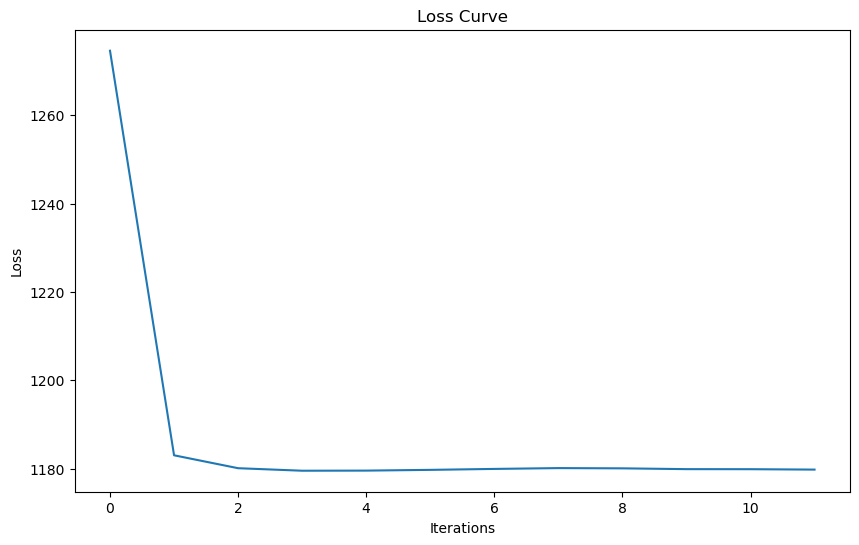

accuracy = 0.9592


In [113]:
# generate data
# X_data, y_data, mislabel = generate_data() 

# split data
# generate data
dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel = {}'.format(mislabel))

indices = np.arange(len(X_data))
np.random.shuffle(indices)
split = int(len(X_data) * 0.75)
# train : test = 3 : 1
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X_data[train_index], y_data[train_index]
X_test, y_test = X_data[test_index], y_data[test_index]

model1 = SVM1(dim)
model1.fit(X_train, y_train)
print('accuracy = {:.4f}'.format(model1.score(X_test, y_test)))


mislabel:0.022


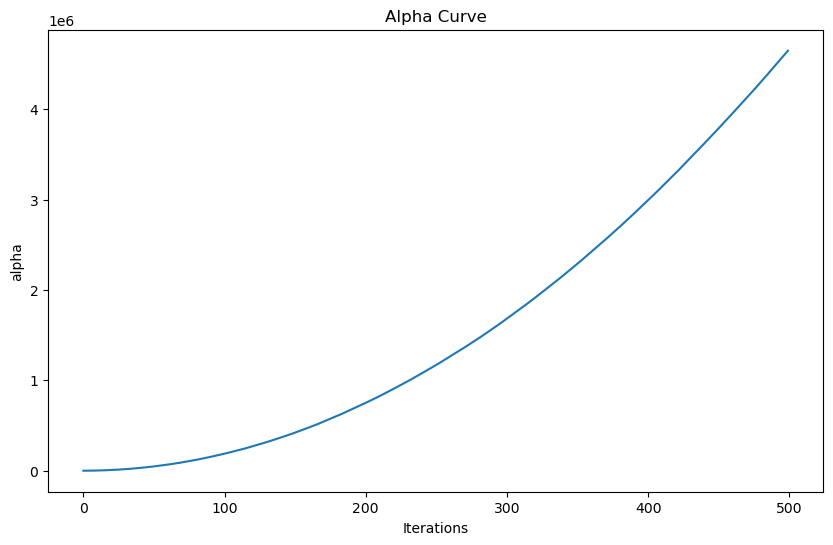

accuracy:0.9080


In [114]:
dim, num = (10, 1000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
indices = np.arange(len(X_data))
np.random.shuffle(indices)
split = int(len(X_data) * 0.75)
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X_data[train_index], y_data[train_index]
X_test, y_test = X_data[test_index], y_data[test_index]
# constrcut model and train (remember record time)
model1 = SVM2(dim)
model1.fit(X_train, y_train)
print('accuracy:{:.4f}'.format(model1.score(X_test, y_test)))


# predict and compare your results

In [115]:
# sklearn (20维 10000样本数据集)
from sklearn.svm import LinearSVC

# generate data
dim, num = (20, 10000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
indices = np.arange(len(X_data))
np.random.shuffle(indices)
split = int(len(X_data) * 0.75)
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X_data[train_index], y_data[train_index]
X_test, y_test = X_data[test_index], y_data[test_index]

# constrcut model and train (remember record time)
modelSVM = LinearSVC(fit_intercept=0, dual=False)
modelSVM.fit(X_train, y_train.flatten())
print('accuracy:{:.4f}'.format(modelSVM.score(X_test, y_test)))

mislabel:0.0349
accuracy:0.9588


In [116]:
from sklearn.svm import LinearSVC

# generate data
dim, num = (10, 1000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
indices = np.arange(len(X_data))
np.random.shuffle(indices)
split = int(len(X_data) * 0.75)
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X_data[train_index], y_data[train_index]
X_test, y_test = X_data[test_index], y_data[test_index]

# constrcut model and train (remember record time)
modelSVM = LinearSVC(fit_intercept=0, dual=False)
modelSVM.fit(X_train, y_train.flatten())
print('accuracy:{:.4f}'.format(modelSVM.score(X_test, y_test)))

mislabel:0.022
accuracy:0.9760


In [117]:
import time
# 单次的数据集对比
dim, num = (10, 1000)
np.random.seed(0)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel:{}'.format(mislabel))

# split data
indices = np.arange(len(X_data))
np.random.shuffle(indices)
split = int(len(X_data) * 0.75)
train_index = indices[:split]
test_index = indices[split:]
X_train, y_train = X_data[train_index], y_data[train_index]
X_test, y_test = X_data[test_index], y_data[test_index]
# constrcut model and train (remember record time)
modelSVM = LinearSVC(fit_intercept = False, dual=False)
model1 = SVM1(dim, plot = False)
model2 = SVM2(dim, plot = False)

time_svm_start = time.time()
modelSVM.fit(X_train, y_train.ravel())
time_svm_end = time.time()

time_model2_start = time.time()
model2.fit(X_train, y_train)
time_model2_end = time.time()

time_model1_start = time.time()
model1.fit(X_train, y_train)
time_model1_end = time.time()

print('LinearSVC accuracy: {:.4f}'.format(modelSVM.score(X_test, y_test)))
print(f'LinearSVC time: {time_svm_end - time_svm_start}s')
print('CustomModel1 accuracy: {:.4f}'.format(model1.score(X_test, y_test)))
print(f'CustomModel1 time: {time_model1_end - time_model1_start}s')
print('CustomModel2 accuracy: {:.4f}'.format(model2.score(X_test, y_test)))
print(f'CustomModel2 time: {time_model2_end - time_model2_start}s')

mislabel:0.022
LinearSVC accuracy: 0.9760
LinearSVC time: 0.0009999275207519531s
CustomModel1 accuracy: 0.9680
CustomModel1 time: 0.012002706527709961s
CustomModel2 accuracy: 0.9080
CustomModel2 time: 21.421135902404785s


In [118]:
from sklearn.svm import LinearSVC
# 四折交叉验证法
dim, num = (10, 1000)
np.random.seed(8)
X_data, y_data, mislabel = generate_data(dim, num)
print('mislabel = {}'.format(mislabel))
full_data = np.hstack((X_data, y_data.reshape(-1, 1)))

class_1_samples = full_data[(y_data == 1.0).flatten(), :]
class_0_samples = full_data[(y_data != 1.0).flatten(), :]
num_class_1 = class_1_samples.shape[0]
num_class_0 = class_0_samples.shape[0]

modelSVM_accuracay = []
model1_accuracay = []
model2_accuracay = []
modelSVM = LinearSVC(fit_intercept = False, dual=False)
model1 = SVM1(dim, plot = False)
model2 = SVM2(dim, plot = False)
for fold in range(4):    # shuffle
    np.random.shuffle(class_1_samples)
    np.random.shuffle(class_0_samples)
    for fold_inner in range(4):
        test_indices_1 = range(fold_inner * num_class_1 // 4, (fold_inner + 1) * num_class_1 // 4)
        train_indices_1 = set(range(num_class_1)) - set(test_indices_1)
        
        test_indices_0 = range(fold_inner * num_class_0 // 4, (fold_inner + 1) * num_class_0 // 4)
        train_indices_0 = set(range(num_class_0)) - set(test_indices_0)
        
        # Create training and testing sets
        training_set_1 = class_1_samples[list(train_indices_1)]
        testing_set_1 = class_1_samples[list(test_indices_1)]
        
        training_set_0 = class_0_samples[list(train_indices_0)]
        testing_set_0 = class_0_samples[list(test_indices_0)]
        
        # Combine and prepare the final training and testing data
        X_train, y_train = np.vstack((training_set_1, training_set_0))[:, :-1], np.vstack((training_set_1, training_set_0))[:, -1]
        X_test, y_test = np.vstack((testing_set_1, testing_set_0))[:, :-1], np.vstack((testing_set_1, testing_set_0))[:, -1]
        
        # Train models and record accuracy
        modelSVM.fit(X_train, y_train.ravel())
        model2.fit(X_train, y_train.reshape(X_train.shape[0], 1))
        model1.fit(X_train, y_train.reshape(X_train.shape[0], 1))
        
        modelSVM_accuracay.append(modelSVM.score(X_test, y_test.ravel()))
        model1_accuracay.append(model1.score(X_test, y_test.reshape(X_test.shape[0], 1)))
        model2_accuracay.append(model2.score(X_test, y_test.reshape(X_test.shape[0], 1)))

print('LinearSVC accuracy: {:.4f}'.format(np.mean(modelSVM_accuracay)))
print('CustomModel1 accuracy: {:.4f}'.format(np.mean(model1_accuracay)))
print('CustomModel2 accuracy: {:.4f}'.format(np.mean(model2_accuracay)))

mislabel = 0.029
LinearSVC accuracy: 0.9528
CustomModel1 accuracy: 0.9548
CustomModel2 accuracy: 0.9455
